# Visualizations, version 4 revision 2

## Setup packages.

In [1]:
require(abind)
require(data.table)
require(magrittr)

require(ggplot2)

Loading required package: abind
Loading required package: data.table
Loading required package: magrittr
Loading required package: ggplot2


## Read data tables.

### 3D dataset.

In [2]:
xs3d <- fread("xs-3d-20200322a.csv")[, case:=factor(case)]
xs3d %>% dim

[1] 1331    4

In [3]:
ys3d <- fread("ys-3d-20200322a.csv")[, case:=factor(case)]
ys3d %>% dim

[1] 27951     5

In [4]:
s3d <- merge(xs3d, ys3d)
s3d %>% dim

[1] 27951     8

## Reorganize as a tensor.

In [5]:
y <- array(
    as.matrix(s3d[order(t, x3, x2, x1)][, .(y1, y2, y3)]),
    dim = c(
        length(unique(s3d$x1)),
        length(unique(s3d$x2)),
        length(unique(s3d$x3)),
        length(unique(s3d$t )),
        3
    ),
    dimnames = list(
        x1=sort(unique(s3d$x1)),
        x2=sort(unique(s3d$x2)),
        x3=sort(unique(s3d$x3)),
        t =sort(unique(s3d$t )),
        i =1:3
    )
)
y %>% dim

[1] 11 11 11 21  3

## Compute differences.

### First differences (Jacobians).

In [6]:
dy1 <- y[2:11, , , , ] - y[1:10, , , , ]
dy2 <- y[, 2:11, , , ] - y[, 1:10, , , ]
dy3 <- y[, , 2:11, , ] - y[, , 1:10, , ]

dy <- abind(
    (dy1[, 2:11, 2:11, , ] + dy1[, 1:10, 1:10, , ]) / 2,
    (dy2[2:11, , 2:11, , ] + dy2[1:10, , 1:10, , ]) / 2,
    (dy3[2:11, 2:11, , , ] + dy3[1:10, 1:10, , , ]) / 2,
    along=6
)
dy %>% dim

[1] 10 10 10 21  3  3

### Second differences (Hessians).

In [7]:
ddy1 <- dy[2:10, , , , , ] - dy[1:9, , , , , ]
ddy2 <- dy[, 2:10, , , , ] - dy[, 1:9, , , , ]
ddy3 <- dy[, , 2:10, , , ] - dy[, , 1:9, , , ]

ddy <- abind(
    (ddy1[, 2:10, 2:10, , , ] + ddy1[, 1:9, 1:9, , , ]) / 2,
    (ddy2[2:10, , 2:10, , , ] + ddy2[1:9, , 1:9, , , ]) / 2,
    (ddy3[2:10, 2:10, , , , ] + ddy3[1:9, 1:9, , , , ]) / 2,
    along=7
)
ddy %>% dim

[1]  9  9  9 21  3  3  3

## Curvatures (determinant of Hessians).

### Compute the tensor.

In [8]:
cy <- array(
    0,
    dim = c(
        dim(ddy)[1],
        dim(ddy)[2],
        dim(ddy)[3],
        dim(ddy)[4],
        dim(ddy)[5]
    ),
    dimnames = list(
        x1=dimnames(y)$x1[2:10],
        x2=dimnames(y)$x2[2:10],
        x3=dimnames(y)$x3[2:10],
        t =dimnames(y)$t,
        i =dimnames(y)$i
    )
)
for (x1 in 1:dim(cy)[1])
    for (x2 in 1:dim(cy)[2])
        for (x3 in 1:dim(cy)[3])
            for(t in 1:dim(cy)[4])
                for (i in 1:dim(cy)[5])
                    cy[x1, x2, x3, t, i] <- det(ddy[x1, x2, x3, t, i, , ])
cy %>% dim

[1]  9  9  9 21  3

### Organize as a data table.

In [9]:
curv <- merge(
    s3d,
    dcast(
        data.table(melt(cy)),
        x1 + x2 + x3 + t ~ i
    )[, .(x1, x2, x3, t, c1=`1`, c2=`2`, c3=`3`)],
    by=c("x1", "x2", "x3", "t")
)[, .(case, t, x1, x2, x3, y1, y2, y3, c1, c2, c3)]
curv %>% head

case,t,x1,x2,x3,y1,y2,y3,c1,c2,c3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
134,0.0,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0,0,0
134,0.5,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0,0,0
134,1.0,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0,0,0
134,1.5,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0,0,0
134,2.0,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0,0,0
134,2.5,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0,0,0


### Save for later use.

In [10]:
save(xs3d, ys3d, s3d, y, dy, ddy, curv, file="visualizations-v4.rdata")

### Plot results.

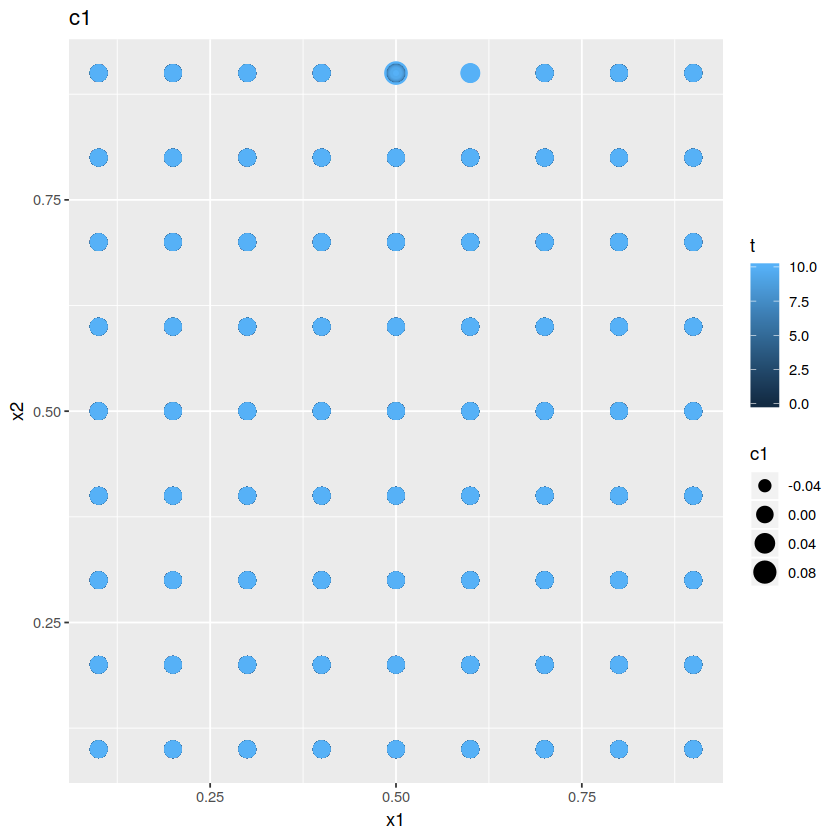

In [11]:
ggplot(curv, aes(x=x1, y=x2, color=t, size=c1)) + geom_point() + ggtitle("c1")

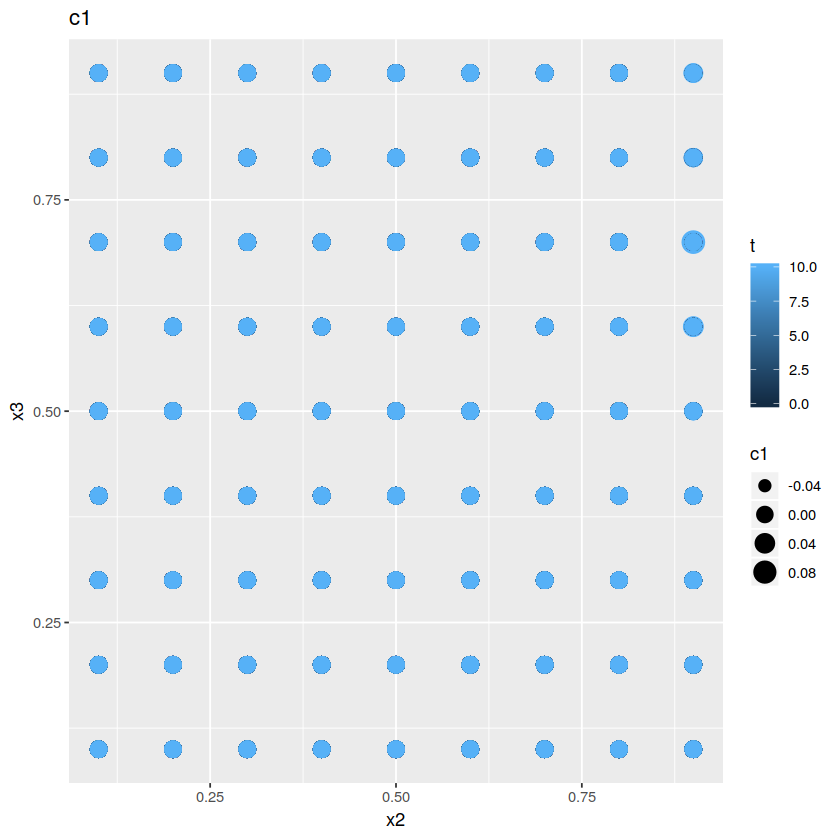

In [12]:
ggplot(curv, aes(x=x2, y=x3, color=t, size=c1)) + geom_point() + ggtitle("c1")

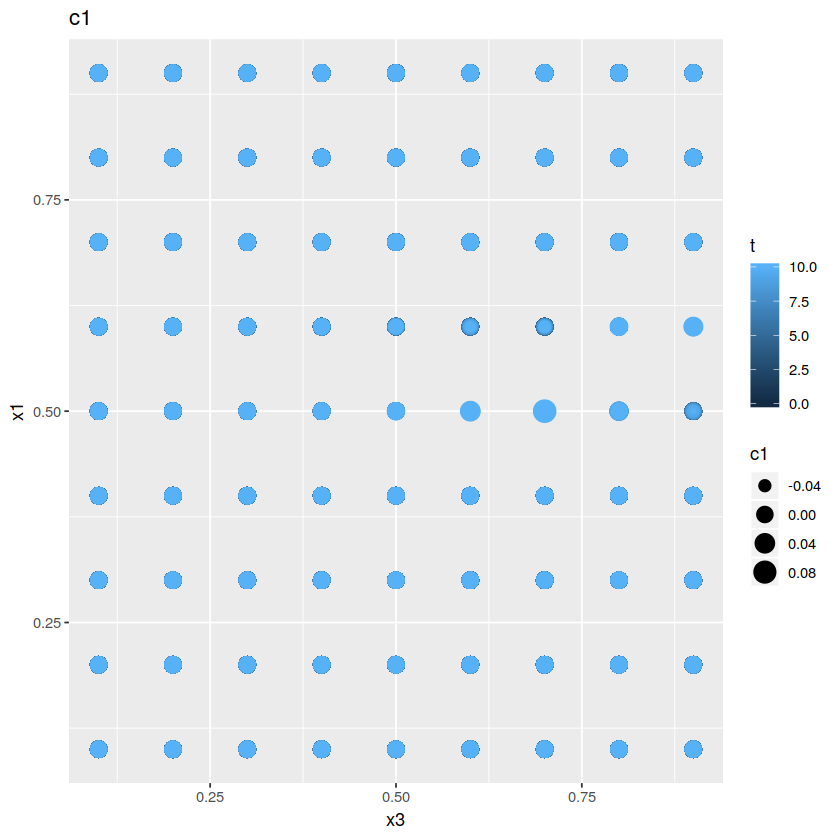

In [13]:
ggplot(curv, aes(x=x3, y=x1, color=t, size=c1)) + geom_point() + ggtitle("c1")

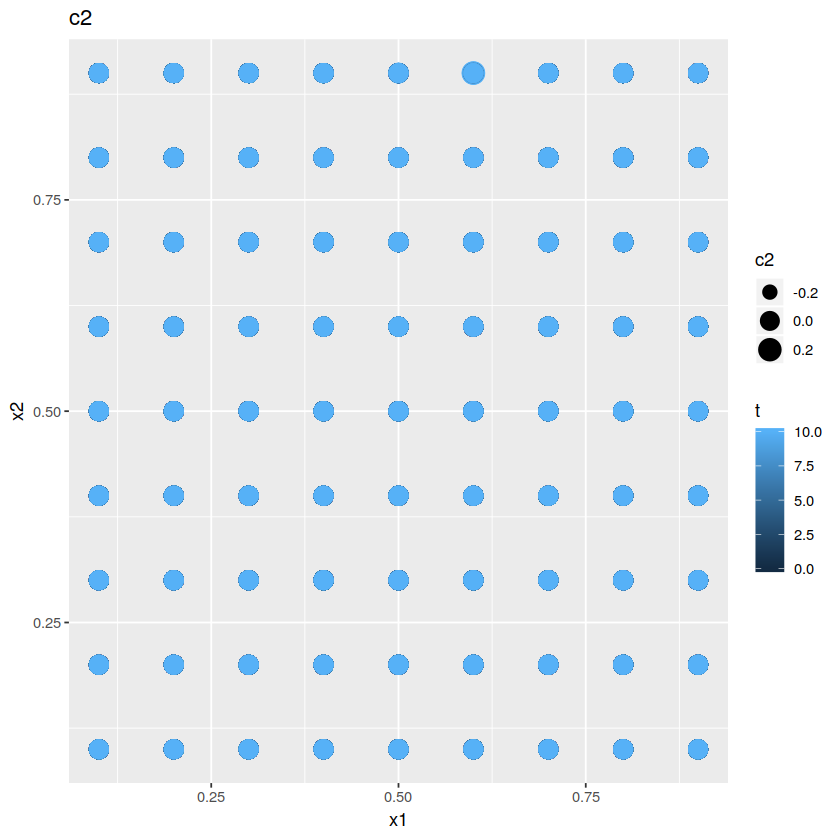

In [14]:
ggplot(curv, aes(x=x1, y=x2, color=t, size=c2)) + geom_point() + ggtitle("c2")

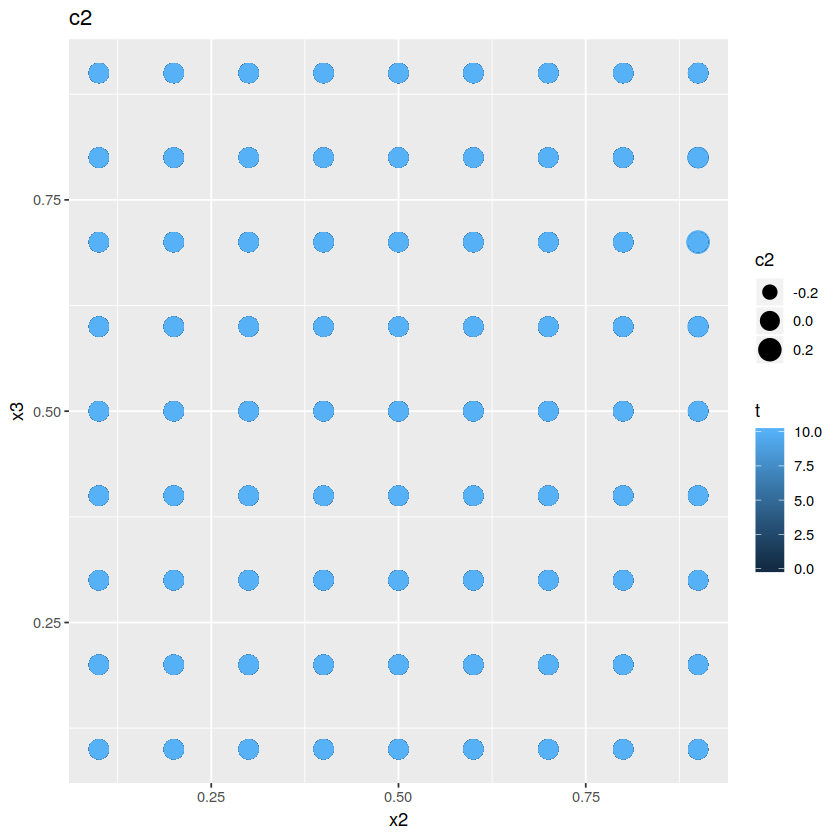

In [15]:
ggplot(curv, aes(x=x2, y=x3, color=t, size=c2)) + geom_point() + ggtitle("c2")

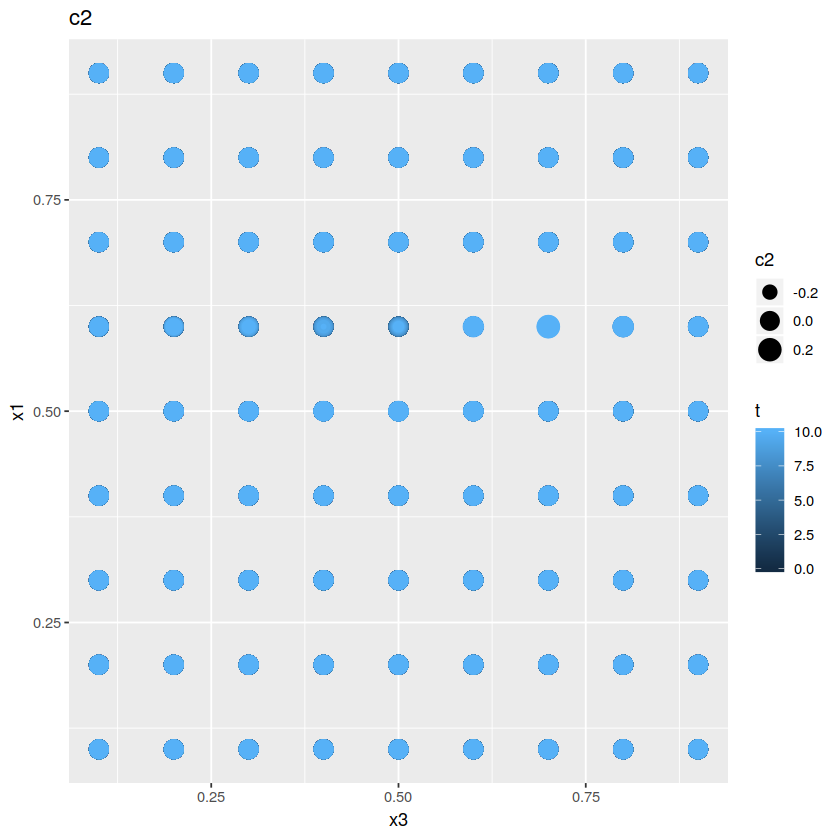

In [16]:
ggplot(curv, aes(x=x3, y=x1, color=t, size=c2)) + geom_point() + ggtitle("c2")

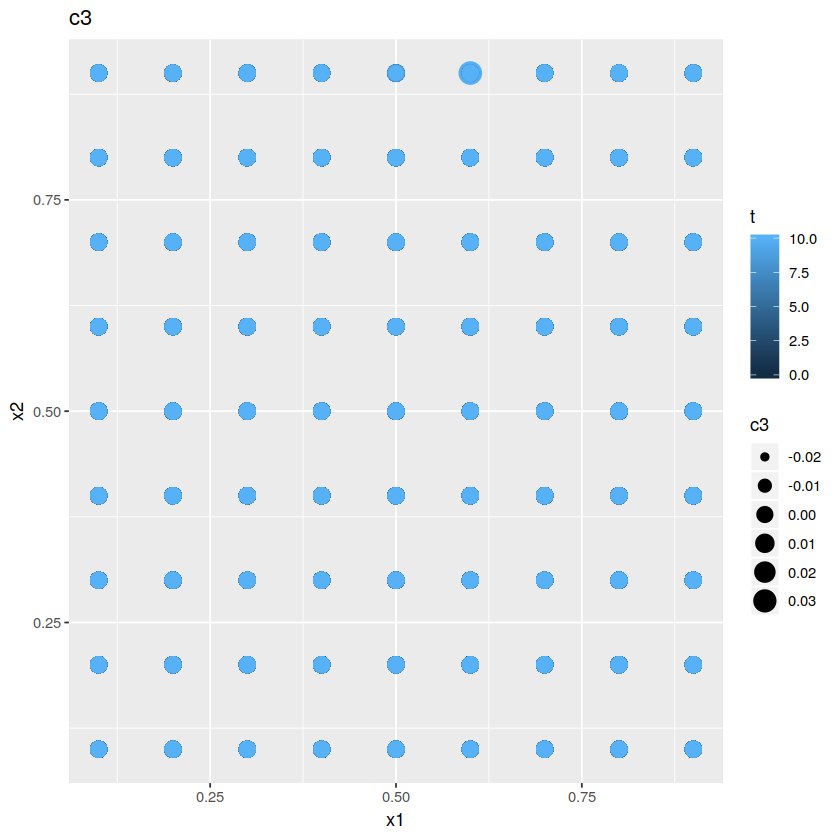

In [17]:
ggplot(curv, aes(x=x1, y=x2, color=t, size=c3)) + geom_point() + ggtitle("c3")

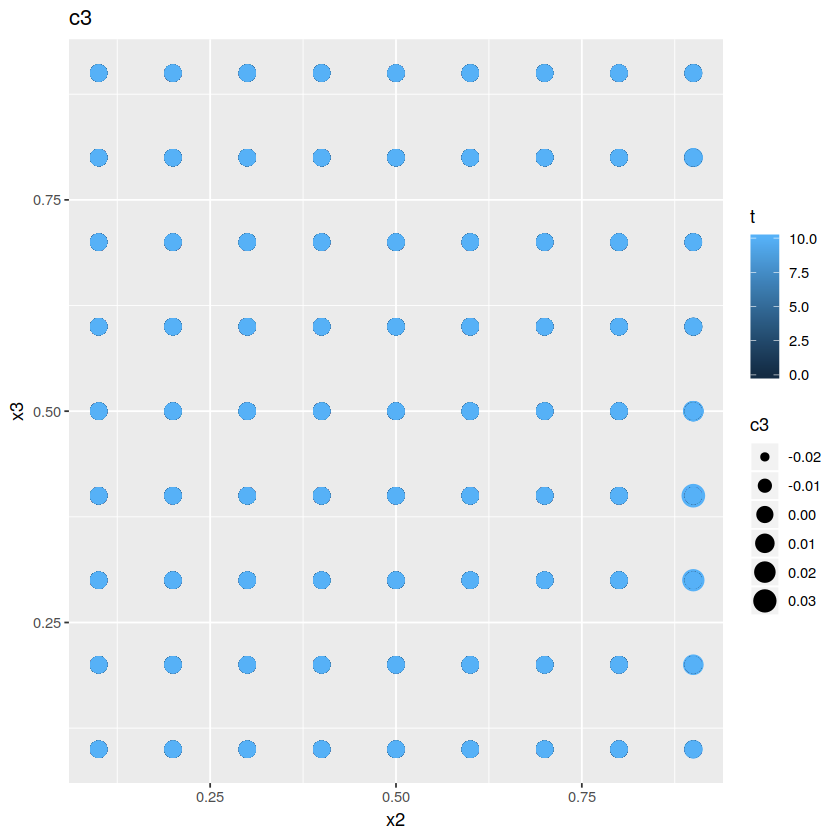

In [18]:
ggplot(curv, aes(x=x2, y=x3, color=t, size=c3)) + geom_point() + ggtitle("c3")

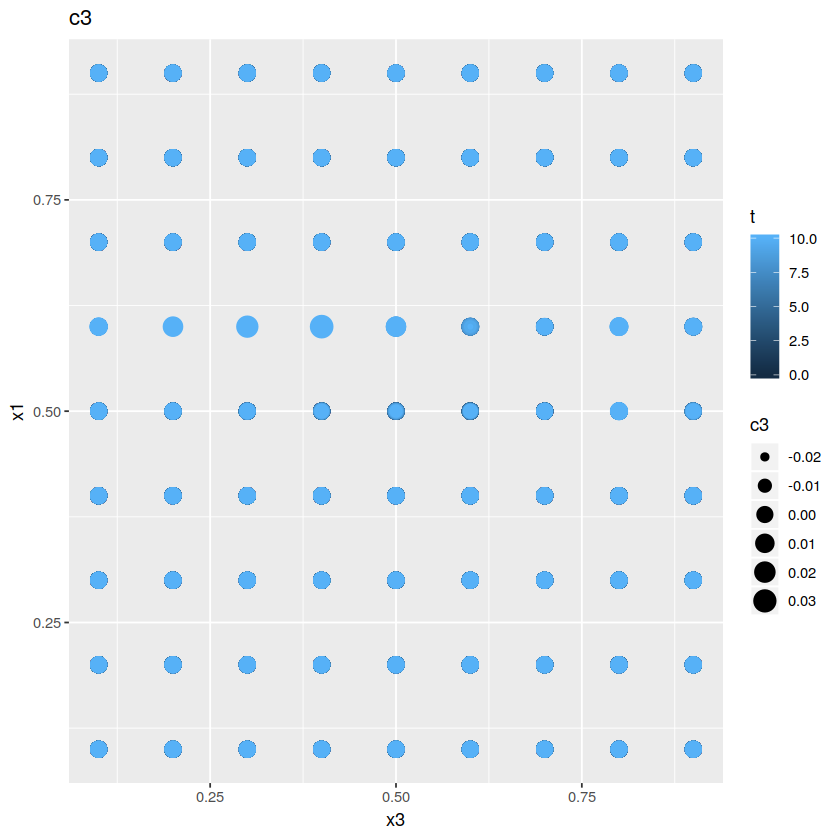

In [19]:
ggplot(curv, aes(x=x3, y=x1, color=t, size=c3)) + geom_point() + ggtitle("c3")

## Curvatures (maximum of Hessians).

### Compute the tensor.

In [20]:
cy <- array(
    0,
    dim = c(
        dim(ddy)[1],
        dim(ddy)[2],
        dim(ddy)[3],
        dim(ddy)[4],
        dim(ddy)[5]
    ),
    dimnames = list(
        x1=dimnames(y)$x1[2:10],
        x2=dimnames(y)$x2[2:10],
        x3=dimnames(y)$x3[2:10],
        t =dimnames(y)$t,
        i =dimnames(y)$i
    )
)
for (x1 in 1:dim(cy)[1])
    for (x2 in 1:dim(cy)[2])
        for (x3 in 1:dim(cy)[3])
            for(t in 1:dim(cy)[4])
                for (i in 1:dim(cy)[5])
                    cy[x1, x2, x3, t, i] <- max(abs(ddy[x1, x2, x3, t, i, , ]))
cy %>% dim

[1]  9  9  9 21  3

### Organize as a data table.

In [21]:
curv <- merge(
    s3d,
    dcast(
        data.table(melt(cy)),
        x1 + x2 + x3 + t ~ i
    )[, .(x1, x2, x3, t, c1=`1`, c2=`2`, c3=`3`)],
    by=c("x1", "x2", "x3", "t")
)[, .(case, t, x1, x2, x3, y1, y2, y3, c1, c2, c3)]
curv %>% head

case,t,x1,x2,x3,y1,y2,y3,c1,c2,c3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
134,0.0,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0.0000000000,0.0000000000,0.0000000000
134,0.5,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0.0009945546,0.0008171719,0.0005845742
134,1.0,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0.0019907097,0.0016354467,0.0011678091
134,1.5,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0.0029884728,0.0024548254,0.0017497040
134,2.0,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0.0039878508,0.0032753088,0.0023302585
134,2.5,0.1,0.1,0.1,-0.190032,0.5144967,0.4093612,0.0049888526,0.0040968980,0.0029094717


### Plot results.

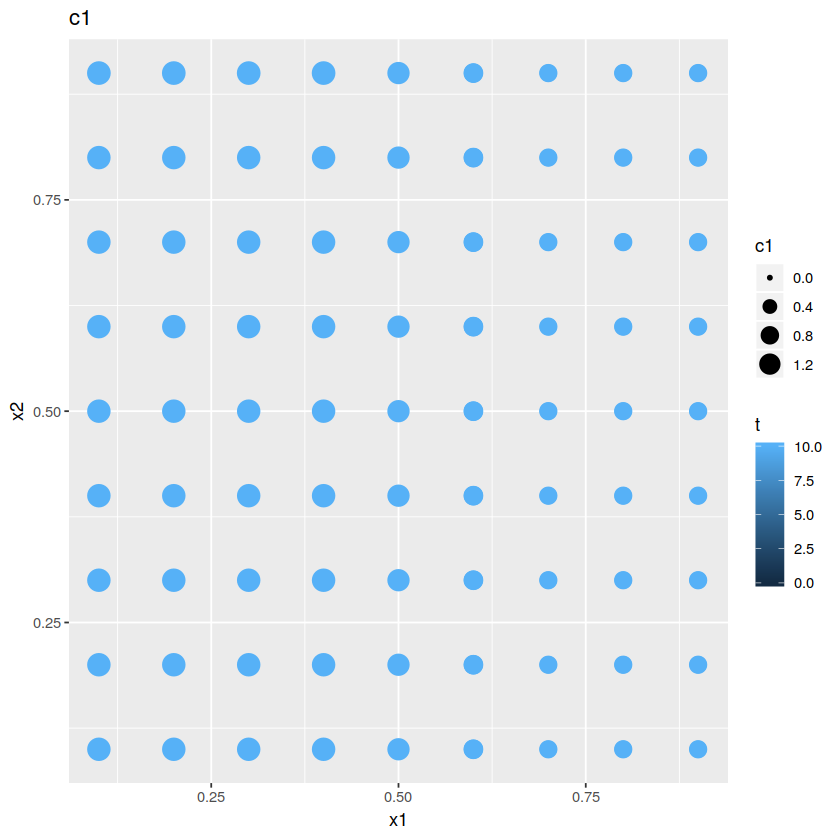

In [22]:
ggplot(curv, aes(x=x1, y=x2, color=t, size=c1)) + geom_point() + ggtitle("c1")

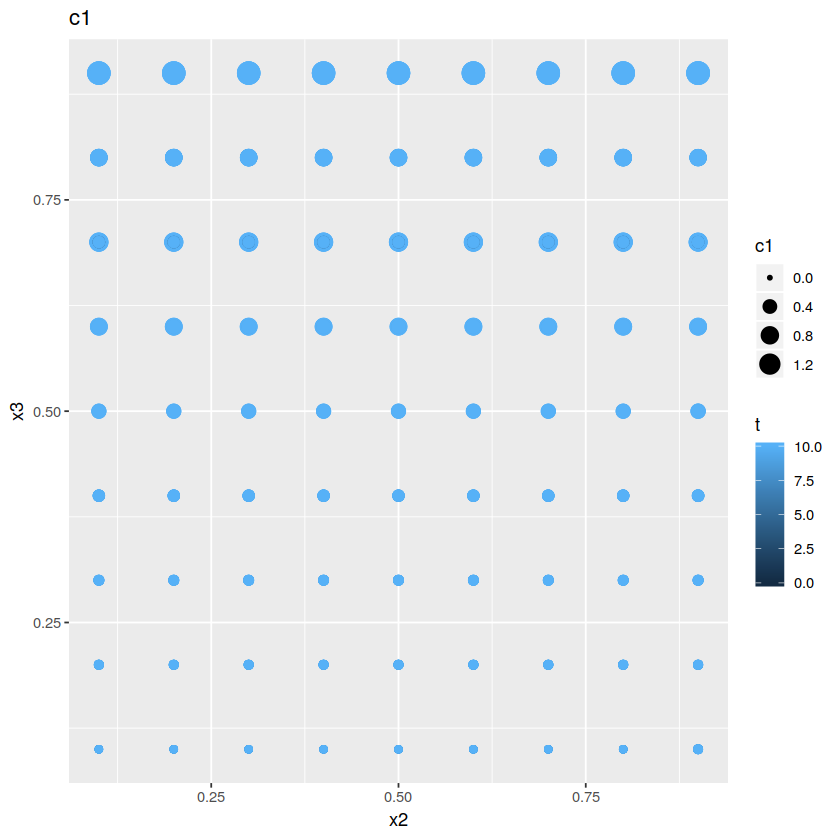

In [23]:
ggplot(curv, aes(x=x2, y=x3, color=t, size=c1)) + geom_point() + ggtitle("c1")

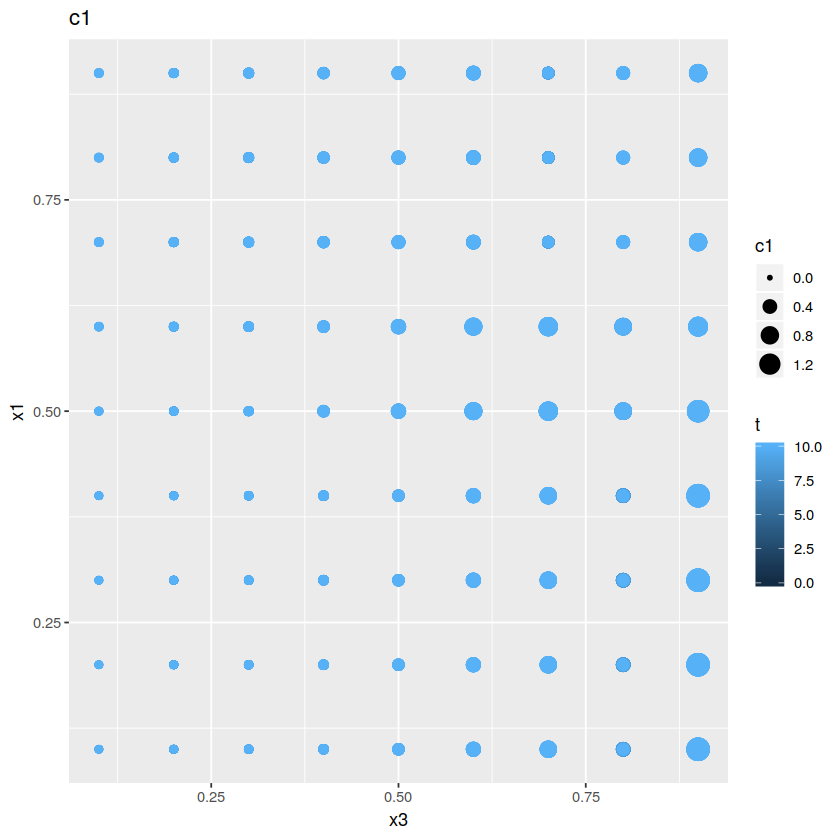

In [24]:
ggplot(curv, aes(x=x3, y=x1, color=t, size=c1)) + geom_point() + ggtitle("c1")

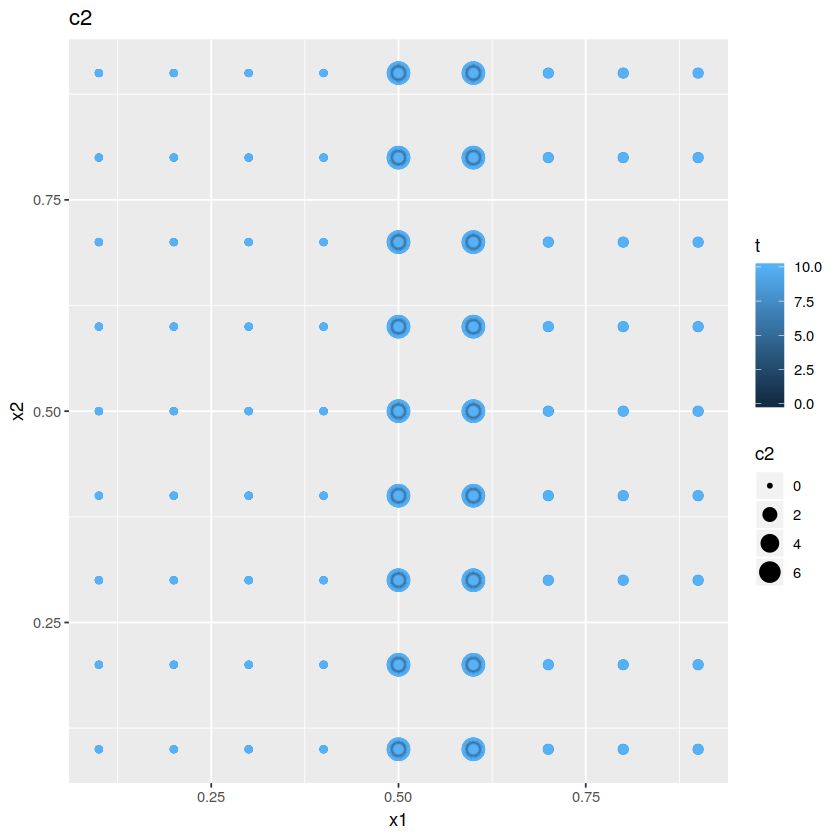

In [25]:
ggplot(curv, aes(x=x1, y=x2, color=t, size=c2)) + geom_point() + ggtitle("c2")

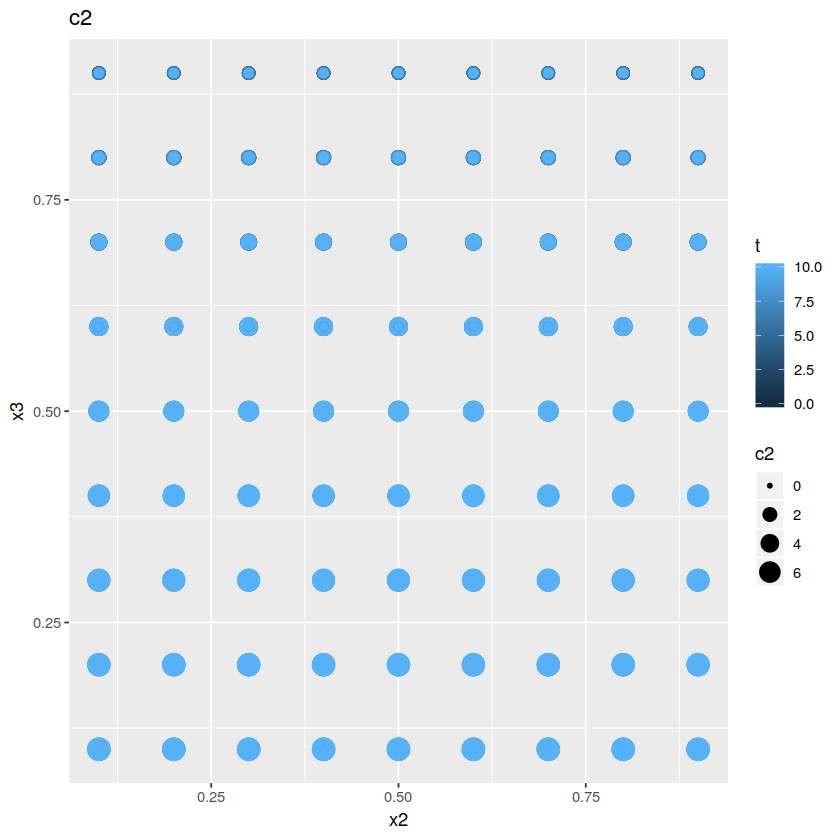

In [26]:
ggplot(curv, aes(x=x2, y=x3, color=t, size=c2)) + geom_point() + ggtitle("c2")

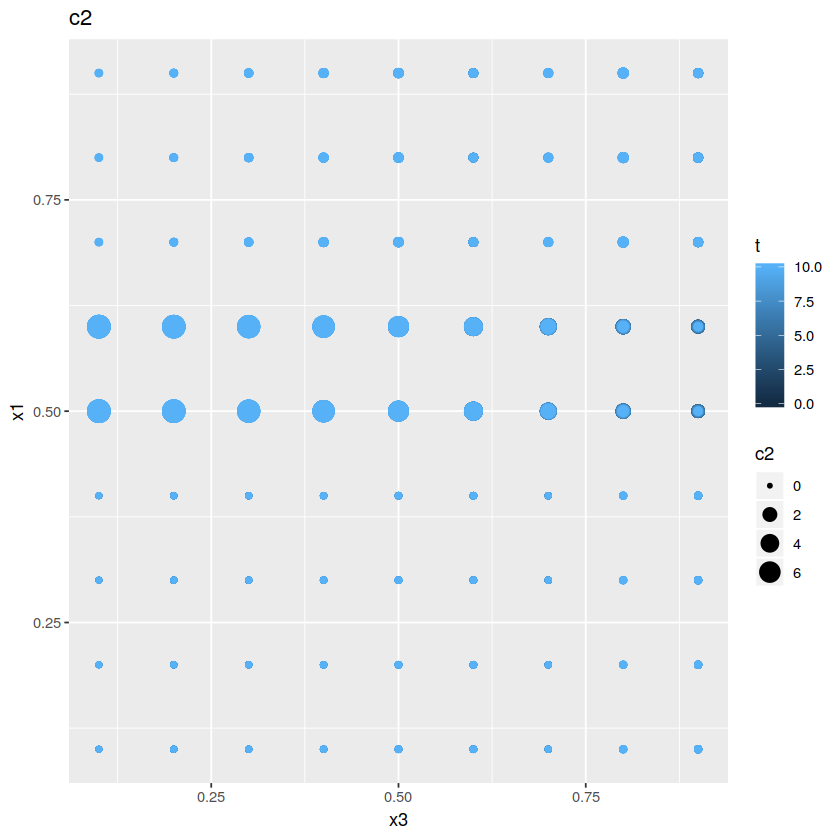

In [27]:
ggplot(curv, aes(x=x3, y=x1, color=t, size=c2)) + geom_point() + ggtitle("c2")

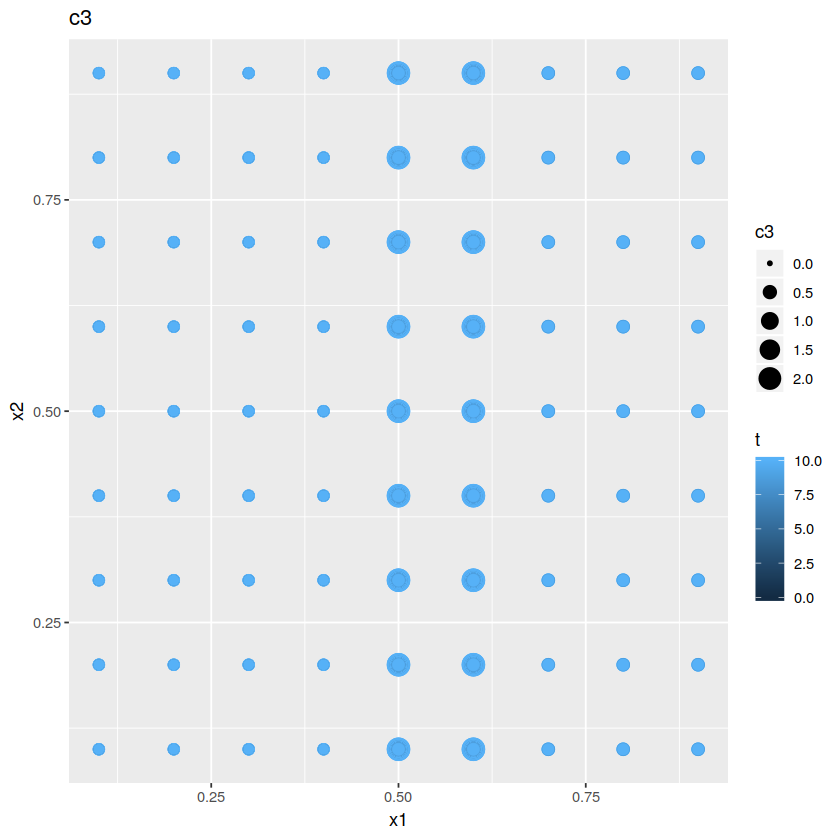

In [28]:
ggplot(curv, aes(x=x1, y=x2, color=t, size=c3)) + geom_point() + ggtitle("c3")

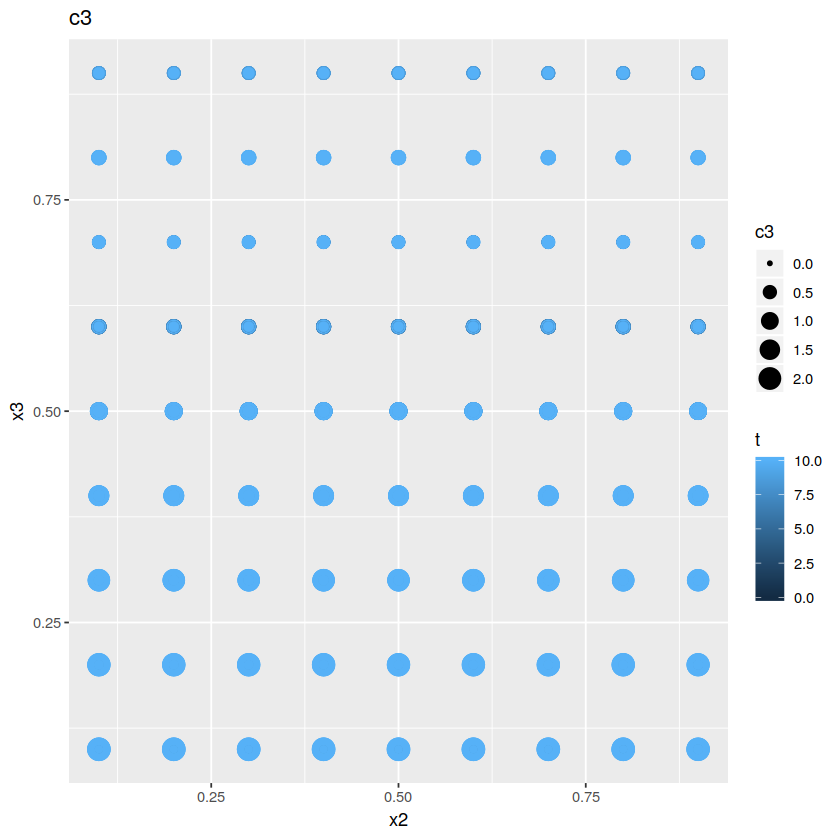

In [29]:
ggplot(curv, aes(x=x2, y=x3, color=t, size=c3)) + geom_point() + ggtitle("c3")

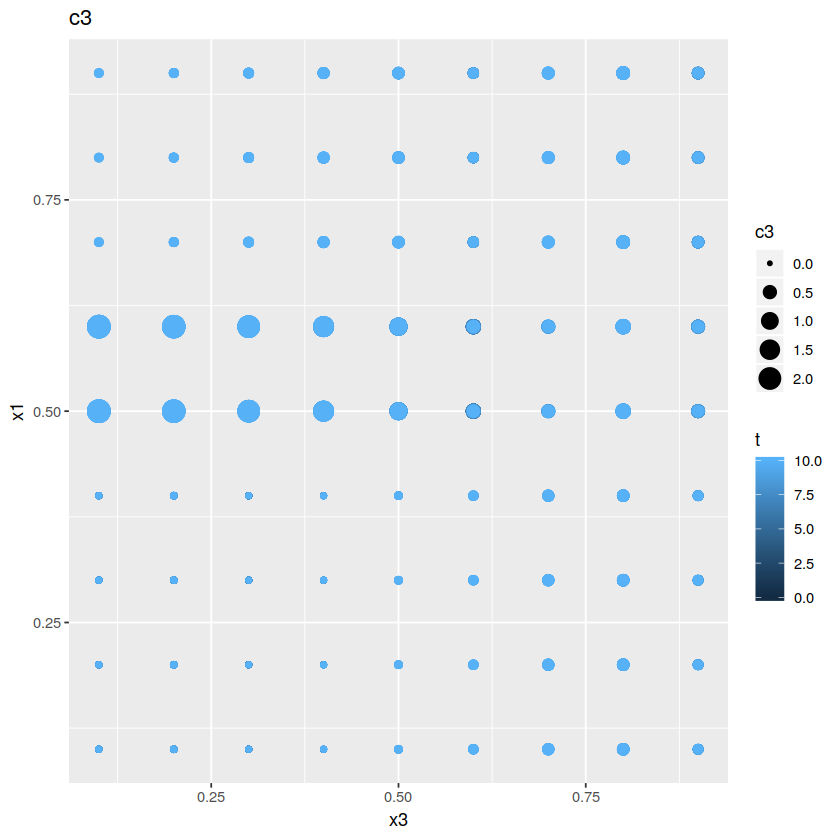

In [30]:
ggplot(curv, aes(x=x3, y=x1, color=t, size=c3)) + geom_point() + ggtitle("c3")